### load data

In [541]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import calendar

In [542]:
test = pd.read_csv('bike_demand_test.csv')
train = pd.read_csv('bike_demand_train.csv')

In [543]:
train.shape

(10886, 12)

In [544]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [545]:
test.shape

(6493, 9)

In [546]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [547]:
full = pd.concat([train,test])

In [548]:
full = full.reset_index().drop('index', axis=1)

### feature engineering

In [549]:
full['datetime'] = pd.to_datetime(full['datetime'])
full['date'] = full['datetime'].apply(lambda x: x.date())
full['hour'] = full['datetime'].apply(lambda x: x.hour)
full['weekday'] = full['datetime'].apply(lambda x: x.weekday())
full['month'] = full['datetime'].apply(lambda x: x.month)
full['year'] = full['datetime'].apply(lambda x: x.year)

In [550]:
full.shape

(17379, 17)

### fill windspeed with 0 values

In [551]:
from sklearn.ensemble import RandomForestRegressor

In [552]:
regressor = RandomForestRegressor()

In [553]:
wind_0 = full[full['windspeed']==0]
wind_not_0 = full[full['windspeed']!=0]

In [554]:
columns_for_predictions = ['season', 'weather', 'humidity', 'month', 'temp','year', 'atemp']

In [555]:
regressor.fit(wind_not_0[columns_for_predictions], wind_not_0['windspeed'])

RandomForestRegressor()

In [556]:
windprediction = regressor.predict(wind_0[columns_for_predictions])

In [557]:
wind_0['windspeed']=windprediction

/var/folders/6h/5k5kd9fs35d2zrg3xjk3d2g80000gn/T/ipykernel_62374/3331354625.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind_0['windspeed']=windprediction


In [558]:
full = pd.concat([wind_0, wind_not_0]).reset_index().drop('index', axis=1)

In [559]:
full.shape

(17379, 17)

In [560]:
full.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,hour,weekday,month,year
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,6.676454,3.0,13.0,16.0,2011-01-01,0,5,1,2011
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,6.689269,8.0,32.0,40.0,2011-01-01,1,5,1,2011
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,6.689269,5.0,27.0,32.0,2011-01-01,2,5,1,2011
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,6.626539,3.0,10.0,13.0,2011-01-01,3,5,1,2011
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,6.626539,0.0,1.0,1.0,2011-01-01,4,5,1,2011


### one-hot encoding

In [561]:
categorical = ['season', 'holiday', 'workingday','weather', 'weekday', 'month', 'year', 'hour']
Numerical = ['temp', 'humidity', 'windspeed', 'atemp']

In [562]:
for variable in categorical:
    full[variable] = full[variable].astype('category')

In [563]:
full = full.sort_values(by='datetime').drop(['datetime', 'date'], axis=1)

In [564]:
full.head(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,weekday,month,year
0,1,0,0,1,9.84,14.395,81,6.676454,3.0,13.0,16.0,0,5,1,2011
1,1,0,0,1,9.02,13.635,80,6.689269,8.0,32.0,40.0,1,5,1,2011
2,1,0,0,1,9.02,13.635,80,6.689269,5.0,27.0,32.0,2,5,1,2011
3,1,0,0,1,9.84,14.395,75,6.626539,3.0,10.0,13.0,3,5,1,2011
4,1,0,0,1,9.84,14.395,75,6.626539,0.0,1.0,1.0,4,5,1,2011


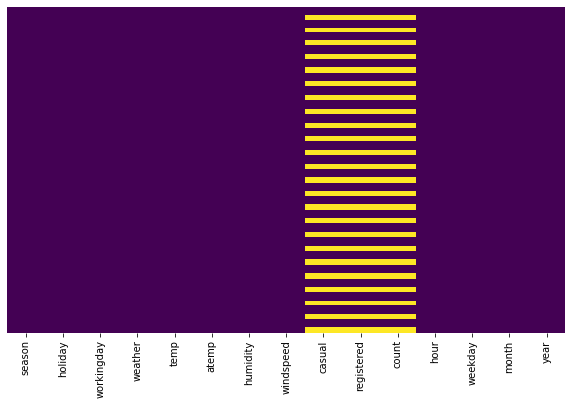

In [565]:
sns.heatmap(full.isnull(), cmap='viridis', yticklabels=[], cbar=False);
fig=plt.gcf()
fig.set_size_inches(10,6);

In [566]:
data = pd.get_dummies(full)

### train_test_split

In [567]:
Xtrain = data[~data['count'].isnull()]
Xtest = data[data['count'].isnull()]
ytrain = Xtrain['count']

In [568]:
Xtrain = Xtrain.drop(['casual','registered', 'count'], axis=1).copy()
Xtest = Xtest.drop(['casual','registered', 'count'], axis=1).copy()

### build a regression model

In [738]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [739]:
lr = LinearRegression()

In [740]:
lr.fit(Xtrain, np.log(ytrain))

LinearRegression()

In [741]:
predict_lr = np.exp(lr.predict(Xtrain))

In [742]:
np.sqrt(mean_squared_error(ytrain, predict_lr))

96.33791952514329

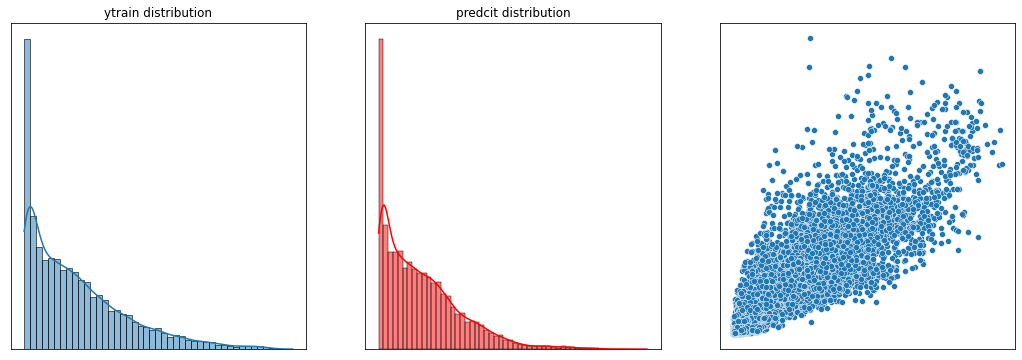

In [743]:
fig, axes = plt.subplots(1,3, figsize=(18,6), subplot_kw=dict(xticks=[],yticks=[]))
sns.histplot(ytrain, kde=True, ax=axes[0])
axes[0].set_title('ytrain distribution')
sns.histplot(predict_lr, kde=True, ax=axes[1], color='r')
axes[1].set_title('predcit distribution')
sns.scatterplot(x=ytrain, y=predict_lr, ax=axes[2]);

### build a lasso model

In [744]:
lasso = Lasso()

In [745]:
lasso.fit(Xtrain, np.log(ytrain))

Lasso()

In [746]:
predict_lasso = np.exp(lasso.predict(Xtrain))

In [747]:
np.sqrt(mean_squared_error(ytrain, predict_lasso))

177.9160711522574

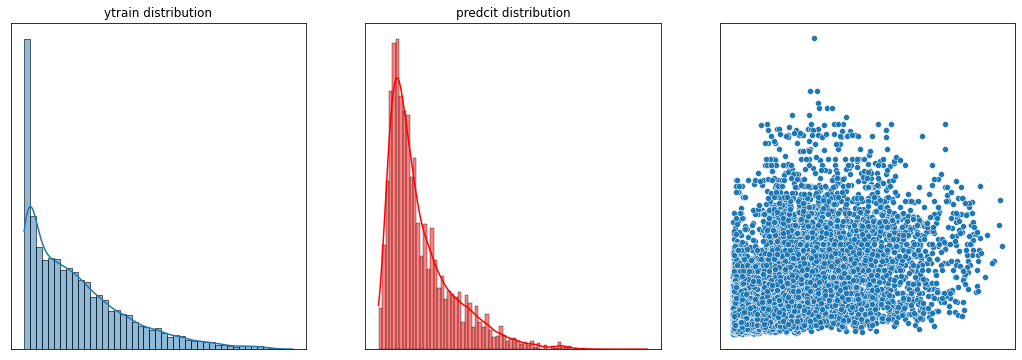

In [748]:
fig, axes = plt.subplots(1,3, figsize=(18,6), subplot_kw=dict(xticks=[],yticks=[]))
sns.histplot(ytrain, kde=True, ax=axes[0])
axes[0].set_title('ytrain distribution')
sns.histplot(predict_lasso, kde=True, ax=axes[1], color='r')
axes[1].set_title('predcit distribution')
sns.scatterplot(x=ytrain, y=predict_lasso, ax=axes[2]);

In [749]:
alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
params= { 'max_iter':[3000],'alpha':alpha}
grid = GridSearchCV(lasso, params, cv=5)

In [750]:
grid.fit(Xtrain,np.log(ytrain))

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([1.00000000e+01, 1.00000000e+00, 5.00000000e-01, 3.33333333e-01,
       2.50000000e-01, 1.00000000e-01, 3.33333333e-02, 1.00000000e-02,
       5.00000000e-03, 3.33333333e-03, 2.50000000e-03, 1.25000000e-03,
       1.11111111e-03, 1.00000000e-03]),
                         'max_iter': [3000]})

In [751]:
predict_lasso_max = np.exp(grid.best_estimator_.predict(Xtrain))

In [752]:
np.sqrt(mean_squared_error(predict_lasso_max, ytrain))

96.93298457127858

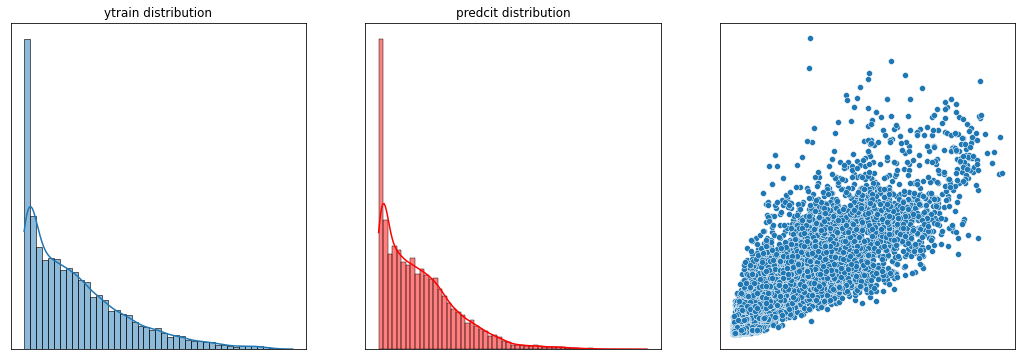

In [753]:
fig, axes = plt.subplots(1,3, figsize=(18,6), subplot_kw=dict(xticks=[],yticks=[]))
sns.histplot(ytrain, kde=True, ax=axes[0])
axes[0].set_title('ytrain distribution')
sns.histplot(predict_lasso_max, kde=True, ax=axes[1], color='r')
axes[1].set_title('predcit distribution')
sns.scatterplot(x=ytrain, y=predict_lasso_max, ax=axes[2]);

### build a ridge model

In [754]:
ridge = Ridge()

In [755]:
ridge.fit(Xtrain, np.log(ytrain))

Ridge()

In [756]:
predict_ridge = np.exp(ridge.predict(Xtrain))

In [757]:
np.sqrt(mean_squared_error(predict_ridge, ytrain))

96.3836964465752

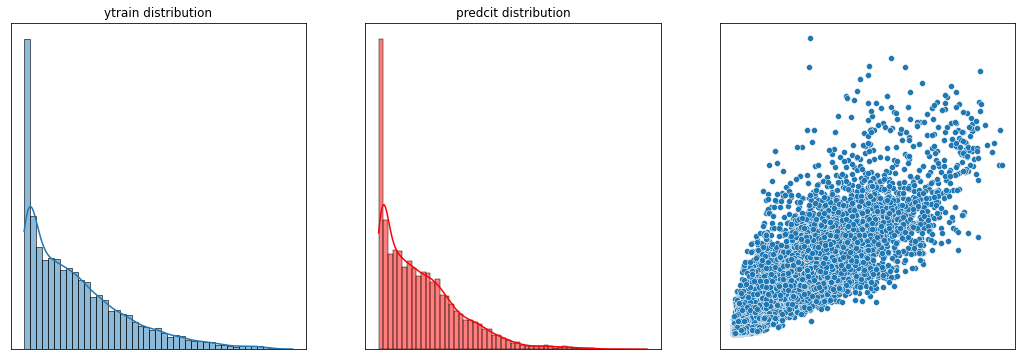

In [758]:
fig, axes = plt.subplots(1,3, figsize=(18,6), subplot_kw=dict(xticks=[],yticks=[]))
sns.histplot(ytrain, kde=True, ax=axes[0])
axes[0].set_title('ytrain distribution')
sns.histplot(predict_ridge, kde=True, ax=axes[1], color='r')
axes[1].set_title('predcit distribution')
sns.scatterplot(x=ytrain, y=predict_ridge, ax=axes[2]);

In [759]:
params = { 'max_iter':[3000],'alpha':[0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
grid = GridSearchCV(ridge, params, cv=5)

In [760]:
grid.fit(Xtrain,np.log(ytrain))

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400,
                                   800, 900, 1000],
                         'max_iter': [3000]})

In [761]:
predict_ridge_max = np.exp(grid.best_estimator_.predict(Xtrain))

In [762]:
np.sqrt(mean_squared_error(predict_ridge_max, ytrain))

96.54081700302608

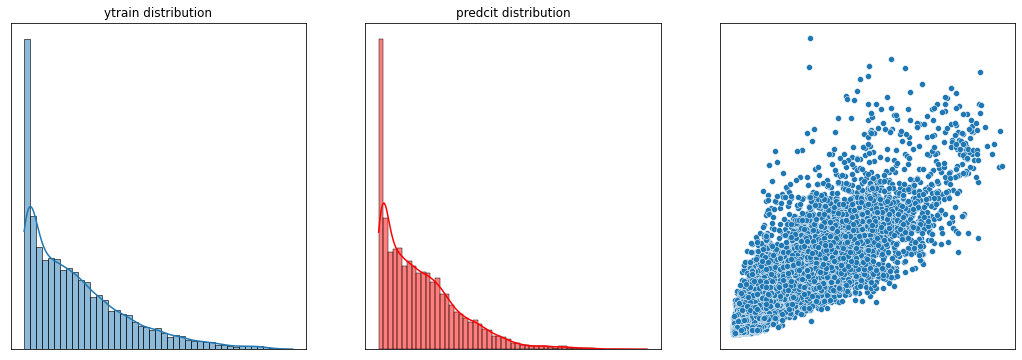

In [763]:
fig, axes = plt.subplots(1,3, figsize=(18,6), subplot_kw=dict(xticks=[],yticks=[]))
sns.histplot(ytrain, kde=True, ax=axes[0])
axes[0].set_title('ytrain distribution')
sns.histplot(predict_ridge_max, kde=True, ax=axes[1], color='r')
axes[1].set_title('predcit distribution')
sns.scatterplot(x=ytrain, y=predict_ridge_max, ax=axes[2]);

### build Random forest regression model

In [764]:
rf = RandomForestRegressor()

In [765]:
rf.fit(Xtrain, np.log(ytrain))

RandomForestRegressor()

In [766]:
prediction_rf = np.exp(rf.predict(Xtrain))

In [767]:
np.sqrt(mean_squared_error(ytrain, prediction_rf))

17.87740536359351

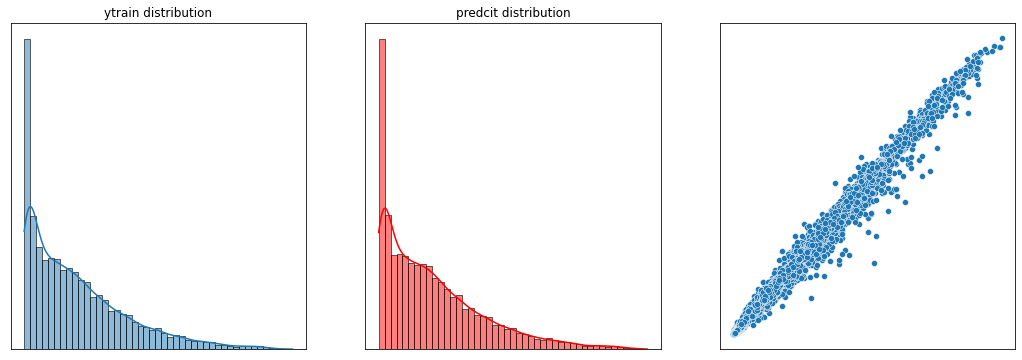

In [768]:
fig, axes = plt.subplots(1,3, figsize=(18,6), subplot_kw=dict(xticks=[],yticks=[]))
sns.histplot(ytrain, kde=True, ax=axes[0])
axes[0].set_title('ytrain distribution')
sns.histplot(prediction_rf, kde=True, ax=axes[1], color='r')
axes[1].set_title('predcit distribution')
sns.scatterplot(x=ytrain, y=prediction_rf, ax=axes[2]);

### build gradient boost model

In [769]:
from sklearn.ensemble import GradientBoostingRegressor

In [770]:
gb = GradientBoostingRegressor()

In [771]:
gb.fit(Xtrain, np.log(ytrain))

GradientBoostingRegressor()

In [772]:
prediction_gb = np.exp(gb.predict(Xtrain))

In [773]:
np.sqrt(mean_squared_error(ytrain, prediction_gb))

92.82470870629454

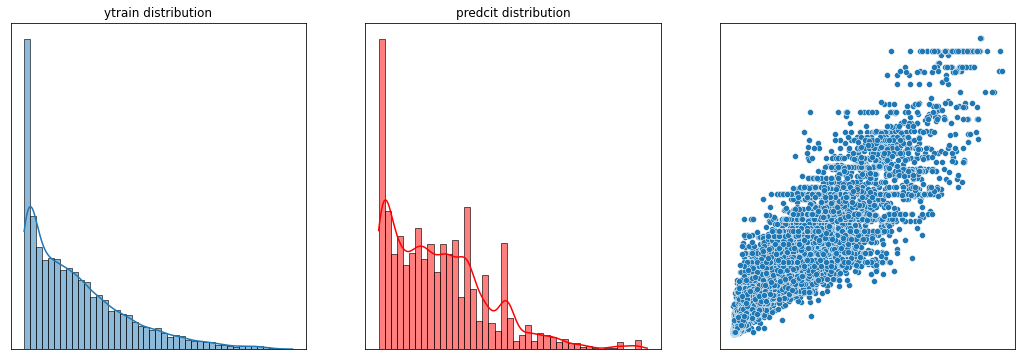

In [774]:
fig, axes = plt.subplots(1,3, figsize=(18,6), subplot_kw=dict(xticks=[],yticks=[]))
sns.histplot(ytrain, kde=True, ax=axes[0])
axes[0].set_title('ytrain distribution')
sns.histplot(prediction_gb, kde=True, ax=axes[1], color='r')
axes[1].set_title('predcit distribution')
sns.scatterplot(x=ytrain, y=prediction_gb, ax=axes[2]);